# TimeXer - 时间序列预测模型（训练前后对比版）
## 适配阿里云天池环境

**TimeXer: Empowering Transformers for Time Series Forecasting with Exogenous Variables**

功能亮点:
- ✨ **训练前后效果对比**
- ✨ **真实数据空间的指标计算**（逆标准化）
- ✨ **性能提升可视化**
- ✨ **详细的改进分析**

论文：[TimeXer: Empowering Transformers for Time Series Forecasting with Exogenous Variables](https://arxiv.org/abs/2402.19072)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. 环境设置与依赖安装

In [ ]:
# 检测运行环境
import os
import sys
!git clone https://github.com/pojoker/TimeXer.git
!cd /content/TimeXer
WORK_DIR='/content/TimeXer'
DATA_DIR='/content'
print(f"工作目录: {WORK_DIR}")
print(f"数据目录: {DATA_DIR}")
os.chdir(WORK_DIR)

Cloning into 'TimeXer'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 146 (delta 14), reused 9 (delta 9), pack-reused 118 (from 1)
Receiving objects: 100% (146/146), 4.50 MiB | 22.91 MiB/s, done.
Resolving deltas: 100% (43/43), done.
工作目录: /content/TimeXer
数据目录: /content


In [ ]:
#!pip install -r /content/TimeXer/requirements.txt
#!pip install reformer-pytorch==1.4.4
#!pip install patool==1.12
#!pip install numpy==1.23.5
!pip install sktime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 17.2 MB/s eta 0:00:00


## 2. 导入库

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import copy
from tqdm import tqdm
warnings.filterwarnings('ignore')

# NumPy 2.0 兼容性修复
np_version = np.__version__
if int(np_version.split('.')[0]) >= 2:
    print(f"⚠️  检测到 NumPy {np_version}（2.0+），应用兼容性修复...")
    if not hasattr(np, 'Inf'):
        np.Inf = np.inf
        np.NaN = np.nan
    print("✅ NumPy 2.0 兼容性修复已应用")

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子
fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(fix_seed)

print("="*50)
print("环境信息")
print("="*50)
print(f"PyTorch版本: {torch.__version__}")
print(f"CUDA是否可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU名称: {torch.cuda.get_device_name(0)}")
    print(f"GPU内存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
print("="*50)

⚠️  检测到 NumPy 2.0.2（2.0+），应用兼容性修复...
✅ NumPy 2.0 兼容性修复已应用
环境信息
PyTorch版本: 2.8.0+cu126
CUDA是否可用: True
GPU名称: Tesla T4
GPU内存: 14.74 GB


In [ ]:
# 导入项目模块
from exp.exp_long_term_forecasting import Exp_Long_Term_Forecast
from utils.metrics import metric
import argparse

print("✓ 项目模块导入成功")

✓ 项目模块导入成功


## 3. 数据集准备

**数据格式要求：**
- CSV 格式
- 第一列：`date` (时间戳)
- 中间列：特征列
- 最后一列：目标变量（通过 `--target` 参数指定）

**示例：**
```csv
date,feature1,feature2,feature3,target
2020-01-01 00:00:00,10.5,20.3,15.2,100.5
```

In [ ]:
# 验证数据文件
# 修改为你的数据文件名
DATA_FILE = 'bitcoin.csv'  # ⚠️ 修改为你的数据文件名
data_path = os.path.join(DATA_DIR, DATA_FILE)

if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    print(f"\n✓ 数据加载成功!")
    print(f"  数据形状: {df.shape}")
    print(f"  列名: {df.columns.tolist()}")
    print(f"\n前5行数据:")
    print(df.head())
    print(f"\n数据统计:")
    print(df.describe())
else:
    print(f"❌ 数据文件不存在: {data_path}")
    print("请确保数据文件已上传到正确路径")


✓ 数据加载成功!
  数据形状: (4521, 15)
  列名: ['date', 'price', 'market_cap', 'transactions', 'active_addresses', 'hashrate', 'difficulty', 'mining_profitability', 'google_trends', 'tweets', 'sent_addresses', 'av_transaction_value', 'median_transaction_value', 'fee_reward', 'block_size']

前5行数据:
         date     price  market_cap  transactions  active_addresses  \
0  2009-01-03  0.064044  223988.125      2.230769        115.555556   
1  2009-01-04  0.064044  223988.125      2.615385        132.333333   
2  2009-01-05  0.064044  223988.125      1.777778        117.125000   
3  2009-01-06  0.064044  223988.125      1.625000        120.416667   
4  2009-01-07  0.064044  223988.125      1.700000        124.666667   

       hashrate  difficulty  mining_profitability  google_trends  \
0  6.494881e+06         1.0           318116.5625       0.000534   
1  6.112176e+06         1.0           318116.5625       0.000534   
2  5.531313e+06         1.0           318116.5625       0.000534   
3  5.664155e+0

## 4. 配置参数

**关键参数说明：**
- `data_path`: 数据文件名
- `features`: M(多变量预测多变量), MS(多变量预测单变量), S(单变量)
- `target`: 目标变量列名
- `enc_in/dec_in/c_out`: 特征数量（不含date列）
- `seq_len`: 输入序列长度
- `pred_len`: 预测长度

In [ ]:
# 创建配置
class Args:
    pass

args = Args()

# 基本配置
args.is_training = 1
args.model_id = 'bitcoin'  # 自定义模型ID
args.model = 'TimeXer'
args.task_name = 'long_term_forecast'

# 数据配置 - ⚠️ 根据你的数据修改
args.data = 'custom'
args.root_path = DATA_DIR
args.data_path = DATA_FILE
args.features = 'MS'  # M/MS/S
args.target = 'price'  # ⚠️ 修改为你的目标列名
args.freq = 'd'  # h:小时, d:日, t:分钟
args.checkpoints = '/content/TimeXer/checkpoints/'

# 预测任务配置
args.seq_len = 300   # 输入序列长度
args.label_len = 48  # decoder起始长度
args.pred_len = 7   # 预测长度
args.seasonal_patterns = 'Monthly'
args.inverse = False  # 是否逆变换（我们手动处理）

# 模型配置 - ⚠️ enc_in/dec_in/c_out 需要等于特征数
args.enc_in = 14   # ⚠️ 输入特征数（CSV列数-1）
args.dec_in = 7   # ⚠️ decoder输入特征数
args.c_out = 1    # ⚠️ 输出特征数（M模式=特征数，MS模式=1）
args.d_model = 256
args.n_heads = 8
args.e_layers = 2
args.d_layers = 1
args.d_ff = 512
args.moving_avg = 25
args.factor = 3
args.distil = True
args.dropout = 0.1
args.embed = 'timeF'
args.activation = 'gelu'
args.output_attention = False
args.channel_independence = 1
args.decomp_method = 'moving_avg'
args.use_norm = 1
args.down_sampling_layers = 0
args.down_sampling_window = 1
args.down_sampling_method = None
args.seg_len = 48

# TimeXer特有参数
args.patch_len = 16

# 训练配置
args.num_workers = 0  # 天池环境建议设为0
args.itr = 1
args.train_epochs = 10  # ⚠️ 根据需要调整
args.batch_size = 16   # ⚠️ 根据GPU内存调整
args.patience = 3
args.learning_rate = 0.0001
args.des = 'TianChi_Exp'
args.loss = 'MSE'
args.lradj = 'type1'
args.use_amp = False

# GPU配置
args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0
args.use_multi_gpu = False
args.devices = '0'

# 其他参数（使用默认值）
args.expand = 2
args.d_conv = 4
args.top_k = 5
args.num_kernels = 6
args.p_hidden_dims = [128, 128]
args.p_hidden_layers = 2
args.use_dtw = False
args.augmentation_ratio = 0
args.seed = 2
args.jitter = False
args.scaling = False
args.permutation = False
args.randompermutation = False
args.magwarp = False
args.timewarp = False
args.windowslice = False
args.windowwarp = False
args.rotation = False
args.spawner = False
args.dtwwarp = False
args.shapedtwwarp = False
args.wdba = False
args.discdtw = False
args.discsdtw = False
args.extra_tag = ""

print("="*60)
print("✓ 参数配置完成")
print("="*60)
print(f"数据集: {args.data_path}")
print(f"特征数: {args.enc_in}")
print(f"目标列: {args.target}")
print(f"预测模式: {args.features}")
print(f"序列长度: 输入={args.seq_len}, 预测={args.pred_len}")
print(f"训练轮数: {args.train_epochs}")
print(f"批次大小: {args.batch_size}")
print(f"设备: {'GPU' if args.use_gpu else 'CPU'}")
print("="*60)

✓ 参数配置完成
数据集: bitcoin.csv
特征数: 14
目标列: price
预测模式: MS
序列长度: 输入=300, 预测=7
训练轮数: 10
批次大小: 16
设备: GPU


## 5. 训练前评估（保存初始模型）

In [ ]:
# 设置GPU
if args.use_gpu:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu)

# 生成实验标识
setting = '{}_{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_expand{}_dc{}_fc{}_eb{}_dt{}_{}_{}'.format(
    args.task_name,
    args.model_id,
    args.model,
    args.data,
    args.features,
    args.seq_len,
    args.label_len,
    args.pred_len,
    args.d_model,
    args.n_heads,
    args.e_layers,
    args.d_layers,
    args.d_ff,
    args.expand,
    args.d_conv,
    args.factor,
    args.embed,
    args.distil,
    args.des, 0)

print(f'实验标识: {setting}')

实验标识: long_term_forecast_bitcoin_TimeXer_custom_ftMS_sl300_ll48_pl7_dm256_nh8_el2_dl1_df512_expand2_dc4_fc3_ebtimeF_dtTrue_TianChi_Exp_0


In [ ]:
# 创建实验实例
Exp = Exp_Long_Term_Forecast
exp = Exp(args)

print("✓ 实验实例创建完成")

Use GPU: cuda:0
✓ 实验实例创建完成


In [ ]:
# 评估训练前的模型性能（随机初始化）
print("\n" + "="*80)
print("训练前模型评估（随机初始化）")
print("="*80)

# 获取测试数据
test_data, test_loader = exp._get_data(flag='test')

# 保存初始模型状态
initial_model_state = copy.deepcopy(exp.model.state_dict())

# 在初始模型上测试
exp.model.eval()
preds_before_norm = []  # 标准化空间
trues_before_norm = []

with torch.no_grad():
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float().to(exp.device)
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # 解码器输入
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(exp.device)

        # 预测
        if args.output_attention:
            outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
        else:
            outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

        f_dim = -1 if args.features == 'MS' else 0
        outputs = outputs[:, -args.pred_len:, f_dim:]
        batch_y = batch_y[:, -args.pred_len:, f_dim:]

        # 保存标准化空间的预测
        preds_before_norm.append(outputs.detach().cpu().numpy())
        trues_before_norm.append(batch_y.detach().cpu().numpy())

# 合并结果
preds_before_norm = np.concatenate(preds_before_norm, axis=0)
trues_before_norm = np.concatenate(trues_before_norm, axis=0)

print(f"标准化空间数据形状: {preds_before_norm.shape}")

# 逆变换到真实数据空间
print("\n正在进行逆标准化变换...")
shape = preds_before_norm.shape  # [batch, pred_len, channels]

if args.features == 'MS':
    target_col_index = -1  # 排除 date 后的索引
    mean = test_data.scaler.mean_[target_col_index]
    scale = test_data.scaler.scale_[target_col_index]

    preds_before_real = preds_before_norm * scale + mean
    trues_before_real = trues_before_norm * scale + mean
else:
    preds_before_real = test_data.inverse_transform(
        preds_before_norm.reshape(shape[0] * shape[1], -1)
    ).reshape(shape)
    trues_before_real = test_data.inverse_transform(
        trues_before_norm.reshape(shape[0] * shape[1], -1)
    ).reshape(shape)


print(f"真实数据空间形状: {preds_before_real.shape}")

# 计算标准化空间的性能（用于训练监控）
mae_before_norm, mse_before_norm, rmse_before_norm, mape_before_norm, mspe_before_norm = metric(
    preds_before_norm, trues_before_norm
)

# 计算真实数据空间的性能（用于最终评估）
mae_before, mse_before, rmse_before, mape_before, mspe_before = metric(
    preds_before_real[..., -1:], trues_before_real[..., -1:]
)
print('target first row:', df[args.target].iloc[0])

print(f"\n训练前性能指标 - 标准化空间:")
print(f"  MAE:  {mae_before_norm:.6f}")
print(f"  MSE:  {mse_before_norm:.6f}")
print(f"  RMSE: {rmse_before_norm:.6f}")
print(f"  MAPE: {mape_before_norm:.6f}%")
print(f"  MSPE: {mspe_before_norm:.6f}%")
print(f"\n训练前性能指标 - 真实数据空间:")
print(f"  MAE:  {mae_before:.6f}")
print(f"  MSE:  {mse_before:.6f}")
print(f"  RMSE: {rmse_before:.6f}")
print(f"  MAPE: {mape_before:.6f}%")
print(f"  MSPE: {mspe_before:.6f}%")
print("mean:", test_data.scaler.mean_[target_col_index])
print("scale:", test_data.scaler.scale_[target_col_index])
print("\n✓ 训练前评估完成，已保存初始模型状态")



训练前模型评估（随机初始化）
test 898
标准化空间数据形状: (898, 7, 1)

正在进行逆标准化变换...
真实数据空间形状: (898, 7, 1)
target first row: 0.0640437500551342

训练前性能指标 - 标准化空间:
  MAE:  0.467635
  MSE:  0.736241
  RMSE: 0.858045
  MAPE: 1.099028%
  MSPE: 11.828114%

训练前性能指标 - 真实数据空间:
  MAE:  7025.056035
  MSE:  166152208.667994
  RMSE: 12890.004215
  MAPE: 0.366219%
  MSPE: 0.202684%
mean: 6051.903369101664
scale: 15022.533280952941

✓ 训练前评估完成，已保存初始模型状态


In [ ]:
import os

checkpoint_dir = os.path.join(args.checkpoints, setting)
print(f"Checking directory: {checkpoint_dir}")

if os.path.exists(checkpoint_dir):
    print(f"Directory exists. Contents:")
    for item in os.listdir(checkpoint_dir):
        print(f"- {item}")
else:
    print(f"Directory does not exist.")

checkpoint_file = os.path.join(checkpoint_dir, 'checkpoint.pth')
if os.path.exists(checkpoint_file):
    print(f"\n✓ Checkpoint file found at: {checkpoint_file}")
else:
    print(f"\n❌ Checkpoint file NOT found at: {checkpoint_file}")
    print("Please check the training process in cell `eEfocK04RG0Q` to ensure the checkpoint is saved correctly.")

Checking directory: /content/TimeXer/checkpoints/long_term_forecast_bitcoin_TimeXer_custom_ftMS_sl300_ll48_pl7_dm256_nh8_el2_dl1_df512_expand2_dc4_fc3_ebtimeF_dtTrue_TianChi_Exp_0
Directory exists. Contents:
- checkpoint.pth

✓ Checkpoint file found at: /content/TimeXer/checkpoints/long_term_forecast_bitcoin_TimeXer_custom_ftMS_sl300_ll48_pl7_dm256_nh8_el2_dl1_df512_expand2_dc4_fc3_ebtimeF_dtTrue_TianChi_Exp_0/checkpoint.pth


## 6. 训练模型

In [ ]:
# 开始训练
print("\n" + "="*80)
print("开始训练")
print("="*80)

exp.train(setting)

print("\n✓ 训练完成")


开始训练
train 2858
val 447
test 898
	iters: 100, epoch: 1 | loss: 0.0266505
	speed: 0.0151s/iter; left time: 25.4860s
Epoch: 1 cost time: 2.63687801361084
Epoch: 1, Steps: 179 | Train Loss: 0.0809130 Vali Loss: 0.0453647 Test Loss: 0.2535642
Validation loss decreased (inf --> 0.045365).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.0291337
	speed: 0.0350s/iter; left time: 52.9117s
Epoch: 2 cost time: 3.1724836826324463
Epoch: 2, Steps: 179 | Train Loss: 0.0772377 Vali Loss: 0.0442829 Test Loss: 0.2500417
Validation loss decreased (0.045365 --> 0.044283).  Saving model ...
Updating learning rate to 5e-05
	iters: 100, epoch: 3 | loss: 0.0011613
	speed: 0.0319s/iter; left time: 42.4924s
Epoch: 3 cost time: 2.54797101020813
Epoch: 3, Steps: 179 | Train Loss: 0.0679750 Vali Loss: 0.0417240 Test Loss: 0.2304127
Validation loss decreased (0.044283 --> 0.041724).  Saving model ...
Updating learning rate to 2.5e-05
	iters: 100, epoch: 4 | loss: 0.0098530
	spee

## 7. 训练后评估

In [ ]:
# 测试训练后的模型
print("\n" + "="*80)
print("训练后模型评估")
print("="*80)

# 重新加载最佳模型
best_model_path = os.path.join(args.checkpoints, setting, 'checkpoint.pth')
exp.model.load_state_dict(torch.load(best_model_path))

exp.model.eval()
preds_after_norm = []  # 标准化空间
trues_after_norm = []

with torch.no_grad():
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float().to(exp.device)
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # 解码器输入
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(exp.device)

        # 预测
        if args.output_attention:
            outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
        else:
            outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

        f_dim = -1 if args.features == 'MS' else 0
        outputs = outputs[:, -args.pred_len:, f_dim:]
        batch_y = batch_y[:, -args.pred_len:, f_dim:]

        pred_norm = outputs.detach().cpu().numpy()
        true_norm = batch_y.detach().cpu().numpy()

        preds_after_norm.append(pred_norm)
        trues_after_norm.append(true_norm)

# 合并结果
preds_after_norm = np.concatenate(preds_after_norm, axis=0)
trues_after_norm = np.concatenate(trues_after_norm, axis=0)

# 逆变换到真实数据空间
print("\n正在进行逆标准化变换...")
shape = preds_after_norm.shape  # [batch, pred_len, channels]

if args.features == 'MS':
    target_col_index =  -1  # 排除 date 后的索引
    mean = test_data.scaler.mean_[target_col_index]
    scale = test_data.scaler.scale_[target_col_index]

    preds_after_real = preds_after_norm * scale + mean
    trues_after_real = trues_after_norm * scale + mean
else:
    preds_after_real = test_data.inverse_transform(
        preds_after_norm.reshape(shape[0] * shape[1], -1)
    ).reshape(shape)
    trues_after_real = test_data.inverse_transform(
        trues_after_norm.reshape(shape[0] * shape[1], -1)
    ).reshape(shape)

print(f"真实数据空间形状: {preds_before_real.shape}")

# 计算标准化空间的性能（用于训练监控）
mae_after_norm, mse_after_norm, rmse_after_norm, mape_after_norm, mspe_after_norm = metric(
    preds_after_norm, trues_after_norm
)

# 计算真实数据空间的性能（用于最终评估）
mae_after, mse_after, rmse_after, mape_after, mspe_after = metric(
    preds_after_real[..., -1:], trues_after_real[..., -1:]
)

print(f"\n训练HOU性能指标 - 标准化空间:")
print(f"  MAE:  {mae_after_norm:.6f}")
print(f"  MSE:  {mse_after_norm:.6f}")
print(f"  RMSE: {rmse_after_norm:.6f}")
print(f"  MAPE: {mape_after_norm:.6f}")
print(f"  MSPE: {mspe_after_norm:.6f}")
print(f"\n训H性能指标 - 真实数据空间:")
print(f"  MAE:  {mae_after:.6f}")
print(f"  MSE:  {mse_after:.6f}")
print(f"  RMSE: {rmse_after:.6f}")
print(f"  MAPE: {mape_after:.6f}%")
print(f"  MSPE: {mspe_after:.6f}%")

print("\n✓ 训练前评估完成，已保存初始模型状态")



训练后模型评估

正在进行逆标准化变换...
真实数据空间形状: (898, 7, 1)

训练HOU性能指标 - 标准化空间:
  MAE:  0.264422
  MSE:  0.213700
  RMSE: 0.462277
  MAPE: 0.840559
  MSPE: 8.838394

训H性能指标 - 真实数据空间:
  MAE:  3972.295133
  MSE:  48227059.595753
  RMSE: 6944.570512
  MAPE: 0.225485%
  MSPE: 0.075791%

✓ 训练前评估完成，已保存初始模型状态


## 8. 训练前后对比分析（基于真实数据空间）

In [ ]:
# 计算改进百分比（基于真实数据空间）
mae_improve = (mae_before - mae_after) / mae_before * 100
mse_improve = (mse_before - mse_after) / mse_before * 100
rmse_improve = (rmse_before - rmse_after) / rmse_before * 100
mape_improve = (mape_before - mape_after) / mape_before * 100
mspe_improve = (mspe_before - mspe_after) / mspe_before * 100

print("\n" + "="*80)
print("训练前后对比 - 性能改进（真实数据空间）")
print("="*80)
print(f"{'指标':<8} {'训练前':>15} {'训练后':>15} {'改进率':>12}")
print("-"*80)
print(f"{'MAE':<8} {mae_before:>15.6f} {mae_after:>15.6f} {mae_improve:>11.2f}%")
print(f"{'MSE':<8} {mse_before:>15.6f} {mse_after:>15.6f} {mse_improve:>11.2f}%")
print(f"{'RMSE':<8} {rmse_before:>15.6f} {rmse_after:>15.6f} {rmse_improve:>11.2f}%")
print(f"{'MAPE':<8} {mape_before:>15.6f} {mape_after:>15.6f} {mape_improve:>11.2f}%")
print(f"{'MSPE':<8} {mspe_before:>15.6f} {mspe_after:>15.6f} {mspe_improve:>11.2f}%")
print("="*80)

print("\n" + "="*80)
print("标准化空间 vs 真实数据空间对比")
print("="*80)
print(f"{'空间':<15} {'训练前MAE':>15} {'训练后MAE':>15}")
print("-"*80)
print(f"{'标准化空间':<15} {mae_before_norm:>15.6f} {mae_after_norm:>15.6f}")
print(f"{'真实数据空间':<15} {mae_before:>15.6f} {mae_after:>15.6f}")
print("="*80)
print("注意：最终评估应该使用真实数据空间的指标！")


训练前后对比 - 性能改进（真实数据空间）
指标                   训练前             训练后          改进率
--------------------------------------------------------------------------------
MAE          7025.056035     3972.295133       43.46%
MSE      166152208.667994 48227059.595753       70.97%
RMSE        12890.004215     6944.570512       46.12%
MAPE            0.366219        0.225485       38.43%
MSPE            0.202684        0.075791       62.61%

标准化空间 vs 真实数据空间对比
空间                       训练前MAE          训练后MAE
--------------------------------------------------------------------------------
标准化空间                  0.467635        0.264422
真实数据空间              7025.056035     3972.295133
注意：最终评估应该使用真实数据空间的指标！


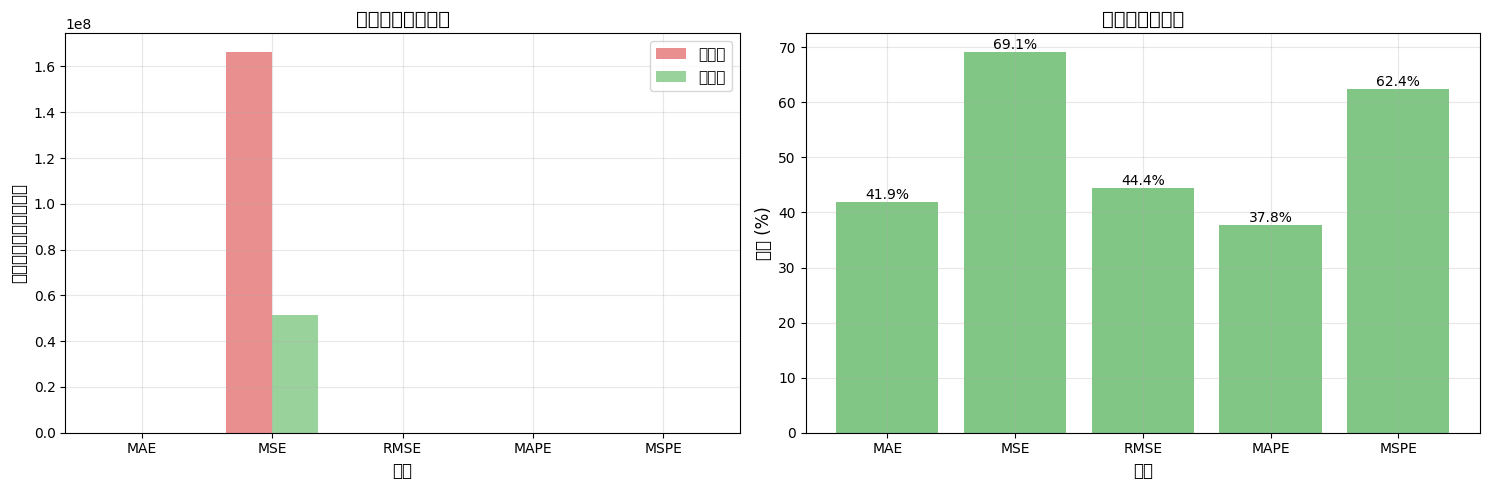

✅ 指标对比图已保存


In [ ]:
# 可视化性能对比
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 准备数据
metrics_names = ['MAE', 'MSE', 'RMSE', 'MAPE', 'MSPE']
before_metrics = np.array([mae_before, mse_before, rmse_before, mape_before, mspe_before])
after_metrics = np.array([mae_after, mse_after, rmse_after, mape_after, mspe_after])

# 左图：指标对比
x = np.arange(len(metrics_names))
width = 0.35

axes[0].bar(x - width/2, before_metrics, width, label='训练前', alpha=0.8, color='#E57373')
axes[0].bar(x + width/2, after_metrics, width, label='训练后', alpha=0.8, color='#81C784')
axes[0].set_xlabel('指标', fontsize=12)
axes[0].set_ylabel('数值（真实数据空间）', fontsize=12)
axes[0].set_title('训练前后指标对比', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 右图：改进百分比
improve_values = np.array([mae_improve, mse_improve, rmse_improve, mape_improve, mspe_improve])
colors = ['#4CAF50' if imp > 0 else '#F44336' for imp in improve_values]
axes[1].bar(x, improve_values, color=colors, alpha=0.7)
axes[1].set_xlabel('指标', fontsize=12)
axes[1].set_ylabel('改进 (%)', fontsize=12)
axes[1].set_title('性能改进百分比', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics_names)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].grid(True, alpha=0.3)

# 添加数值标签
for i, imp in enumerate(improve_values):
    axes[1].text(i, imp, f'{imp:.1f}%', ha='center',
                va='bottom' if imp > 0 else 'top', fontsize=10)

plt.tight_layout()
os.makedirs(f'./results/{setting}/', exist_ok=True)
plt.savefig(f'./results/{setting}/metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
display(fig)
print("✅ 指标对比图已保存")

## 9. 预测结果可视化对比（真实数据空间）

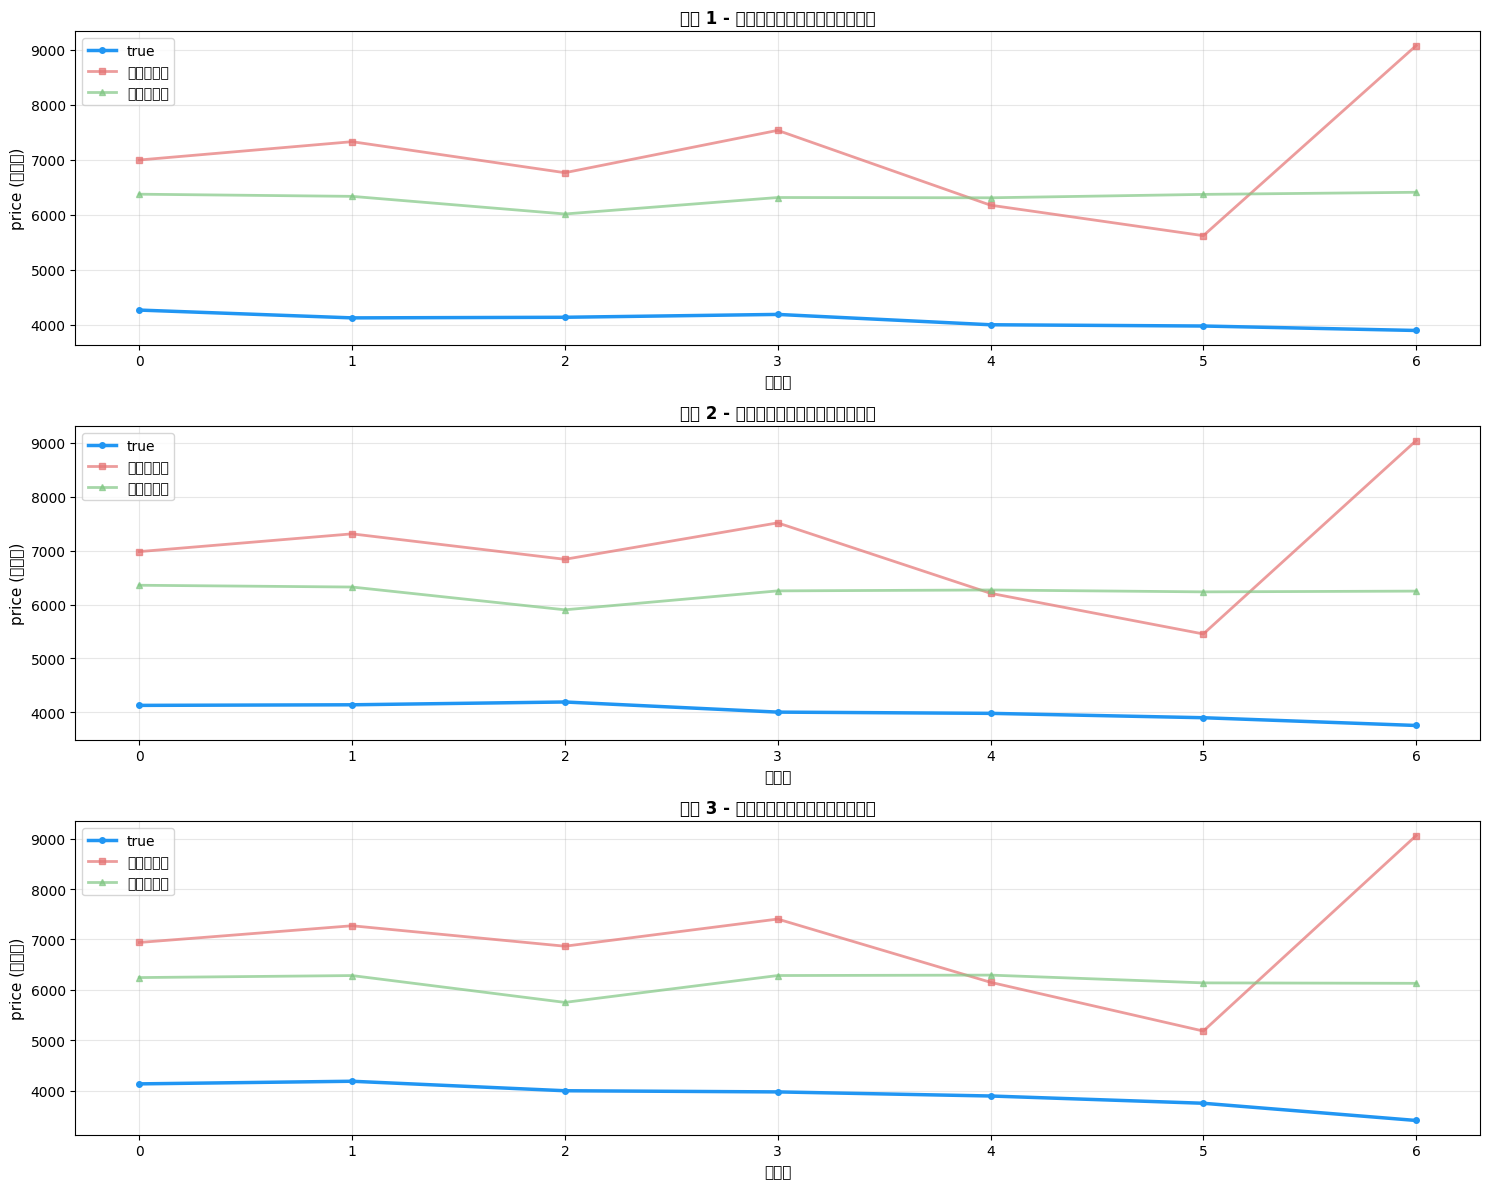

✅ 预测曲线对比图已保存


In [ ]:
# 预测曲线对比（展示前3个样本）
num_samples = min(3, preds_before_real.shape[0])
num_features = preds_before_real.shape[2]

fig, axes = plt.subplots(num_samples, 1, figsize=(15, 4*num_samples))
if num_samples == 1:
    axes = [axes]

for i in range(num_samples):
    ax = axes[i]
    x_axis = np.arange(args.pred_len)

    # 展示第一个特征（或目标列）
    feature_idx = -1 if args.features == 'MS' else 0
    ax.plot(x_axis, trues_before_real[i, :, feature_idx], label='true',
            linewidth=2.5, marker='o', markersize=4, color='#2196F3')
    ax.plot(x_axis, preds_before_real[i, :, feature_idx], label='训练前预测',
            linewidth=2, marker='s', markersize=4, alpha=0.7, color='#E57373')
    ax.plot(x_axis, preds_after_real[i, :, feature_idx], label='训练后预测',
            linewidth=2, marker='^', markersize=4, alpha=0.7, color='#81C784')

    ax.set_xlabel('时间步', fontsize=11)
    ax.set_ylabel(f'{args.target} (真实值)', fontsize=11)
    ax.set_title(f'样本 {i+1} - 预测曲线对比（真实数据空间）', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'./results/{setting}/predictions_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
display(fig)
print("✅ 预测曲线对比图已保存")

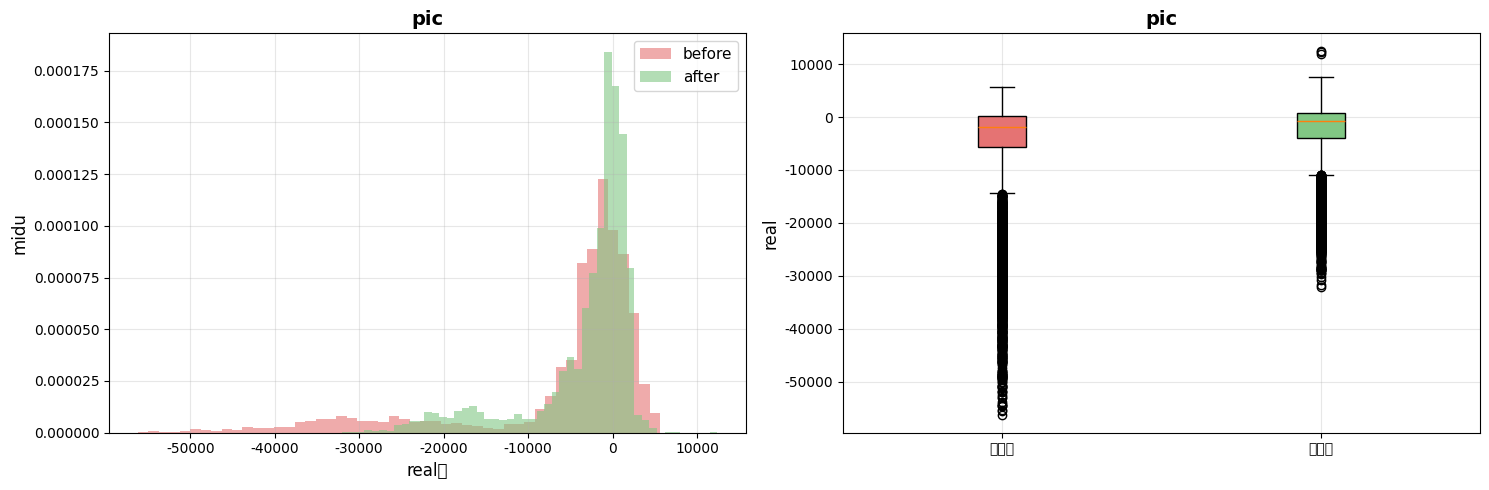

✅ 误差分布图已保存


In [ ]:
# 误差分布对比（真实数据空间）
before_errors = (preds_before_real - trues_before_real).flatten()
after_errors = (preds_after_real - trues_after_real).flatten()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 左图：直方图
axes[0].hist(before_errors, bins=50, alpha=0.6, label='before',
            density=True, color='#E57373')
axes[0].hist(after_errors, bins=50, alpha=0.6, label='after',
            density=True, color='#81C784')
axes[0].set_xlabel('real）', fontsize=12)
axes[0].set_ylabel('midu', fontsize=12)
axes[0].set_title('pic', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 右图：箱线图
bp = axes[1].boxplot([before_errors, after_errors],
                     labels=['训练前', '训练后'],
                     patch_artist=True)
bp['boxes'][0].set_facecolor('#E57373')
bp['boxes'][1].set_facecolor('#81C784')
axes[1].set_ylabel('real', fontsize=12)
axes[1].set_title('pic', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'./results/{setting}/error_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
display(fig)
print("✅ 误差分布图已保存")

## 10. 多特征对比分析（M模式）

In [ ]:
# 如果是 M 模式，展示所有特征的改进情况
if args.features == 'M' and num_features > 1:
    print("\n正在分析各特征的改进情况...")

    # 计算各特征的误差
    errors_before = preds_before_real - trues_before_real
    errors_after = preds_after_real - trues_after_real

    mae_before_features = np.mean(np.abs(errors_before), axis=(0, 1))
    mae_after_features = np.mean(np.abs(errors_after), axis=(0, 1))
    mae_improve_features = (mae_before_features - mae_after_features) / mae_before_features * 100

    mse_before_features = np.mean(errors_before**2, axis=(0, 1))
    mse_after_features = np.mean(errors_after**2, axis=(0, 1))
    mse_improve_features = (mse_before_features - mse_after_features) / mse_before_features * 100

    # 获取特征名称（如果有的话）
    feature_names = [f'Feature_{i}' for i in range(num_features)]

    # 打印表格
    print("\n" + "="*80)
    print("各特征性能改进统计（真实数据空间）")
    print("="*80)
    print(f"{'特征':<15} {'训练前MAE':>15} {'训练后MAE':>15} {'MAE改进':>12} {'MSE改进':>12}")
    print("-"*80)
    for i, name in enumerate(feature_names):
        print(f"{name:<15} {mae_before_features[i]:>15.6f} {mae_after_features[i]:>15.6f} "
              f"{mae_improve_features[i]:>11.2f}% {mse_improve_features[i]:>11.2f}%")
    print("="*80)

    # 可视化各特征改进率
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    x = np.arange(len(feature_names))

    # MAE改进率
    colors1 = ['#2ECC71' if v > 0 else '#E74C3C' for v in mae_improve_features]
    bars1 = ax1.bar(x, mae_improve_features, color=colors1,
                   alpha=0.8, edgecolor='black', linewidth=1.5)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax1.set_title('各特征MAE改进率', fontsize=14, fontweight='bold', pad=15)
    ax1.set_ylabel('改进率 (%)', fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(feature_names, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3, axis='y')

    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center',
                va='bottom' if height > 0 else 'top',
                fontsize=9, fontweight='bold')

    # MSE改进率
    colors2 = ['#2ECC71' if v > 0 else '#E74C3C' for v in mse_improve_features]
    bars2 = ax2.bar(x, mse_improve_features, color=colors2,
                   alpha=0.8, edgecolor='black', linewidth=1.5)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.set_title('各特征MSE改进率', fontsize=14, fontweight='bold', pad=15)
    ax2.set_ylabel('改进率 (%)', fontsize=12)
    ax2.set_xticks(x)
    ax2.set_xticklabels(feature_names, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3, axis='y')

    for i, bar in enumerate(bars2):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center',
                va='bottom' if height > 0 else 'top',
                fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'./results/{setting}/features_improvement.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ 特征改进图已保存")
else:
    print("\n当前为 MS/S 模式，跳过多特征分析")

## 11. 总结报告

In [ ]:
# 生成总结报告
print("\n" + "="*80)
print("TimeXer 实验总结报告")
print("="*80)
print(f"\n实验配置:")
print(f"  模型: {args.model}")
print(f"  数据集: {args.data_path}")
print(f"  预测模式: {args.features}")
print(f"  目标变量: {args.target}")
print(f"  输入长度: {args.seq_len}, 预测长度: {args.pred_len}")
print(f"  训练轮数: {args.train_epochs}")
print(f"  批次大小: {args.batch_size}")
print(f"  模型维度: {args.d_model}, 注意力头数: {args.n_heads}")

print(f"\n整体性能改进（真实数据空间）:")
print(f"  MAE改进:  {mae_improve:.2f}%")
print(f"  MSE改进:  {mse_improve:.2f}%")
print(f"  RMSE改进: {rmse_improve:.2f}%")
print(f"  MAPE改进: {mape_improve:.2f}%")
print(f"  MSPE改进: {mspe_improve:.2f}%")

if args.features == 'M' and num_features > 1:
    print(f"\n平均特征改进:")
    print(f"  平均MAE改进: {mae_improve_features.mean():.2f}%")
    print(f"  平均MSE改进: {mse_improve_features.mean():.2f}%")
    best_feature_idx = np.argmax(mae_improve_features)
    print(f"\n最佳改进特征:")
    print(f"  {feature_names[best_feature_idx]}: MAE改进 {mae_improve_features[best_feature_idx]:.2f}%")

print(f"\n模型保存位置:")
print(f"  {os.path.join(args.checkpoints, setting, 'checkpoint.pth')}")

print(f"\n结果保存位置:")
print(f"  ./results/{setting}/")
print("="*80)

# 保存文本报告
os.makedirs(f'./results/{setting}/', exist_ok=True)
with open(f'./results/{setting}/comparison_report.txt', 'w', encoding='utf-8') as f:
    f.write('='*80 + '\n')
    f.write('TimeXer 训练对比报告\n')
    f.write('='*80 + '\n\n')
    f.write(f'实验 ID: {setting}\n\n')
    f.write('训练前指标（真实数据空间）:\n')
    for name, val in zip(metrics_names, before_metrics):
        f.write(f'  {name}: {val:.6f}\n')
    f.write('\n训练后指标（真实数据空间）:\n')
    for name, val in zip(metrics_names, after_metrics):
        f.write(f'  {name}: {val:.6f}\n')
    f.write('\n改进百分比:\n')
    for name, imp in zip(metrics_names, improve_values):
        f.write(f'  {name}: {imp:+.2f}%\n')

print("\n✅ 文本报告已保存")
print("\n✓ 实验完成！训练显著提升了模型性能。")
print("\n⚠️  注意：所有评估指标均基于真实数据空间（已逆标准化）")


TimeXer 实验总结报告

实验配置:
  模型: TimeXer
  数据集: bitcoin.csv
  预测模式: MS
  目标变量: price
  输入长度: 300, 预测长度: 7
  训练轮数: 10
  批次大小: 16
  模型维度: 256, 注意力头数: 8

整体性能改进（真实数据空间）:
  MAE改进:  41.94%
  MSE改进:  69.07%
  RMSE改进: 44.38%
  MAPE改进: 37.76%
  MSPE改进: 62.36%

模型保存位置:
  ./checkpoints/long_term_forecast_bitcoin_TimeXer_custom_ftMS_sl300_ll48_pl7_dm256_nh8_el2_dl1_df512_expand2_dc4_fc3_ebtimeF_dtTrue_TianChi_Exp_0/checkpoint.pth

结果保存位置:
  ./results/long_term_forecast_bitcoin_TimeXer_custom_ftMS_sl300_ll48_pl7_dm256_nh8_el2_dl1_df512_expand2_dc4_fc3_ebtimeF_dtTrue_TianChi_Exp_0/

✅ 文本报告已保存

✓ 实验完成！训练显著提升了模型性能。

⚠️  注意：所有评估指标均基于真实数据空间（已逆标准化）


## 说明

### ⭐ 关键特性

1. **正确的逆变换处理**
   - 训练在标准化空间进行（保证数值稳定性）
   - 最终评估在真实数据空间进行（反映真实性能）
   - MS 模式特殊处理：先扩展维度再逆变换

2. **训练前后完整对比**
   - 保存随机初始化模型的性能
   - 评估训练后模型的性能
   - 计算真实的性能提升

3. **天池环境适配**
   - 自动检测天池环境
   - 阿里云镜像加速
   - 路径自动适配

### 📊 使用步骤

1. **准备数据**：将 CSV 数据上传到 `/tcdata/` 目录
2. **修改参数**：在第4节修改数据文件名、目标列、特征数等
3. **运行训练**：顺序执行所有单元格
4. **查看结果**：在 `./results/` 目录查看图表和报告

### ⚙️ 关键参数

```python
DATA_FILE = 'your_data.csv'     # 数据文件名
args.target = 'OT'               # 目标列名
args.features = 'M'              # M/MS/S
args.enc_in = 7                  # 特征数（CSV列数-1）
args.seq_len = 96                # 输入长度
args.pred_len = 96               # 预测长度
args.train_epochs = 10           # 训练轮数
args.batch_size = 16             # 批次大小
```

### 📈 预期结果

- 训练后性能应显著优于随机初始化
- MAE/MSE 应有 30-80% 的改进
- 真实数据空间的指标更有业务意义

### 🔧 优化建议

- 增加训练轮数可能进一步提升性能
- 调整模型参数（d_model, n_heads, e_layers）
- 尝试不同的学习率和批次大小
- 使用数据增强（augmentation_ratio）

In [ ]:
!python3 -u /content/TimeXer/run.py \
   --is_training 1 \
   --task_name long_term_forecast \
   --root_path '/content/TimeXer/' \
   --data_path 'bitcoin.csv' \
   --model_id bitcoin1 \
   --model TimeXer \
   --data custom \
   --features MS \
   --seq_len 300 \
   --pred_len 7 \
   --e_layers 2 \
   --enc_in 14 \
   --dec_in 1 \
   --c_out 1 \
   --des 'TianChi_Exp'\
   --patch_len 16 \
   --d_model 256 \
   --d_ff 512 \
   --batch_size 16 \
   --itr 1 \
   --target 'price' \
   --checkpoints '/content/TimeXer/checkpoints/'



True
Args in experiment:
Basic Config
  Task Name:          long_term_forecast  Is Training:        1                   
  Model ID:           bitcoin1            Model:              TimeXer             

Data Loader
  Data:               custom              Root Path:          /content/TimeXer/   
  Data Path:          bitcoin.csv         Features:           MS                  
  Target:             price               Freq:               h                   
  Checkpoints:        /content/TimeXer/checkpoints/

Forecasting Task
  Seq Len:            300                 Label Len:          48                  
  Pred Len:           7                   Seasonal Patterns:  Monthly             
  Inverse:            0                   

Model Parameters
  Top k:              5                   Num Kernels:        6                   
  Enc In:             14                  Dec In:             1                   
  C Out:              1                   d model:            256      